# Naive Bayes classifier with Parzen - Rosenblatt window method

Tuan Minh Le ([link to git repo](https://github.com/TuanMinhLe/Miscellaneous/tree/master/Non_parametric_estimator))

In [1]:
from prettytable import PrettyTable
import math as mt
import numpy as np
from numpy.linalg import inv, det
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

## Introduction

Consider a multidimensional recognition task with assumption that the feature vectors are $i.i.d$. Let $S = \{x_1, x_2, \dots, x_n\}$ be a collection of $n$ observations and $C = \{C_1, C_2, \dots, C_N\}$ be a set of $N$ classes.

Let us recall the Bayes rule:

$$Posteriori = P(C_i|x) = \frac{P(x|C_i) \cdot P(C_i)}{P(x)} = \frac{Likelihood \cdot Priori}{Evidence} \text{ }\text{ }\text{ }\text{ }\text{ }(1).$$

Giving a new vector $x$, a Bayes classifier will decide whether $x$ belongs to a particular class of $C$ by studying its posteriori probabilities, i.e. $x$ is classified into $C_i$ if $i = Argmax = \{P(C_i|x)\}$. Since $P(x)$ is equal for all classes, we can remove it from equation $(1)$ without affecting the decision process. The search for optimal solution now lies in the value of numerator.

In the sections below, we will examine a method to compute these two probabilities. 

## Compute priori probabilities

$P(C_i)$ refers to the expectation of how a new observation occuring before we actually see it. Thus, it is logical to define its value as follow:

$$P(C_i)=\frac{k_i}{n}$$

where $k_i$ and $n$ are the number of samples classified in $C_i$ and the cardinality of the feature space, respectively.

In [2]:
def calculate_prior_probs(num_samples):
    return [item / sum(num_samples) for item in num_samples]

## Estimate likelihoods

Normally, data from real - world issues are drawn from uncommon, mostly multimodal probability density. The idea to tackle this problem is to approximate $P(x|C_i)$ through some of $x$'s neighbors, whom we have known information about.

**P**arzen - **R**osenblatt (**P** - **R**) window method, also known as **K**ernel **D**ensity **E**stimator (**KDE**), is a wide used non - parametric approach. It calculates **PDF** at $x$ by something called density function:

$$P(x|C_i) \approx \hat{f}_h(x) = \frac{1}{n} \sum_{j=1}^n K_h (x-x_j) = \frac{1}{n} \sum_{j=1}^n K\left(\frac{x-x_j}{h}\right)$$

where:

- $\hat{f}_h(x)$ is the kernel function, which is a symmetric multivariate density.

- $n$ is the number of samples in class $C_i$.

- $h$ is the bandwidth of the kernel, which is a positive integer.

The performance of the estimator mainly depends on how we choose $\hat{f}_h(x)$ and $h$. Due to Central limit theorem, most commonly Gaussian distribution is used for the kernel function. Picking the right value of bandwidth could be a challenging task, since we have no knowledge about the underlying density of the dataset. In practice, one should not set the same $h$ for every training space, but to examine different values then decide the best selection.

**PDF** of $d$ - dimensional normal distribution:

$$P(x) = \frac{1}{(2\pi)^{\frac{d}{2}} |\Sigma|^{\frac{1}{2}}} exp\left[\frac{-1}{2} (x-\mu)^T \Sigma^{-1} (x-\mu)\right]$$

where $\mu$ is the mean vector and $\Sigma$ is the covariance matrix.

We then derive Gaussian kernel function as:

$$K_h (x-x_j) = \frac{1}{(2\pi)^{\frac{d}{2}} |\Sigma|^{\frac{1}{2}}} exp\left[\frac{-1}{2} (x-x_j)^T \Sigma^{-1} (x-x_j)\right],$$

then the approximate formula of $likelihood$:

$$P(x|C_i) \approx \frac{1}{n (2\pi)^\frac{d}{2} |\Sigma|^\frac{1}{2}} \sum_{j=1}^n exp\left[\frac{-1}{2} \left(\frac{x-x_j}{h}\right)^T \Sigma^{-1} \left(\frac{x-x_j}{h}\right)\right].$$

In [3]:
def calculate_PR_estimate(x, h, dim, covariance, data):
    PR_estimate = 0
    for x_i in data:
        n = len(data)
        y = x - x_i
        PR_estimate += mt.exp(
            -0.5 * np.matmul(np.matmul(y / h, inv(covariance)), (y / h).T)
        )
        PR_estimate /= n * (2 * mt.pi) ** (dim / 2) * mt.sqrt(det(covariance))

    return PR_estimate

## Test on simulated data

First, let us define some modules for data processing.

In [4]:
def data_generator(dim, num_classes, num_samples, mean, covariance):
    data = []
    labels = []

    for i in range(num_classes):
        class_data = np.random.multivariate_normal(
            mean[i].ravel(), covariance[i], num_samples[i]
        )
        for sample in class_data:
            data.append(list(sample))

        class_labels = i * np.ones(num_samples[i])
        labels = np.append(labels, list(class_labels))

    return np.array(data), labels

In [5]:
def data_2d_visualize(data, labels, likelihood, num_classes, plot_paras):
    x = [[] for i in range(num_classes)]
    y = [[] for i in range(num_classes)]

    for i in range(len(labels)):
        j = int(labels[i])
        x[j].append(data[i][0])
        y[j].append(data[i][1])

    fig = plt.figure(figsize=(18, 8))
    fig.suptitle(plot_paras[0], size=15)

    ax1 = fig.add_subplot(121)
    for i in range(num_classes):
        ax1.scatter(
            x[i],
            y[i],
            marker=plot_paras[1][i],
            color=plot_paras[2][i],
            label="Class " + str(i),
        )

    ax1.set_title("Samples", size=10)
    ax1.set_xlabel("$x$", size=10)
    ax1.set_ylabel("$y$", size=10)
    ax1.legend()

    ax2 = fig.add_subplot(122, projection="3d")
    trisurf = ax2.plot_trisurf(
        data[:, 0], data[:, 1], likelihood, cmap="jet", edgecolor="none",
    )

    ax2.set_title("Class conditional probabilities", size=10)
    ax2.set_xlabel("$x$", size=10)
    ax2.set_ylabel("$y$", size=10)
    ax2.set_zlabel("$P(x|C_i)$", size=10)
    
    plt.show()

For implementing the method, we will use a 2 - dimensional  random dataset from some bivariate normal distribution. Choosing $d=2$ will allow us the luxury of visualization.

In [6]:
dim = 2
num_classes = 4
num_samples = [173, 154, 195, 127]
mean = np.array([[-4.99, 6.78], [1.45, 9.8], [1.33, 4], [-3.12, 3.64]])
covariance = np.array(
    [
        [[3.12, 0.2], [0.2, 1]],
        [[3.06, -0.87], [-0.87, 2.96]],
        [[2.35, -0.38], [-0.38, 2]],
        [[1.23, 1.46], [1.46, 3.1]],
    ]
)

In [7]:
data, labels = data_generator(dim, num_classes, num_samples, mean, covariance)
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.33, random_state=42
)

Module computes likelihood of train - test data.

In [8]:
def calculate_likelihood(data, labels, mean, covariance):
    likelihood = []
    for i in range(len(labels)):
        j = int(labels[i])
        likelihood.append(multivariate_normal.pdf(data[i], mean[j], covariance[j]))

    return likelihood

Visualize train set.

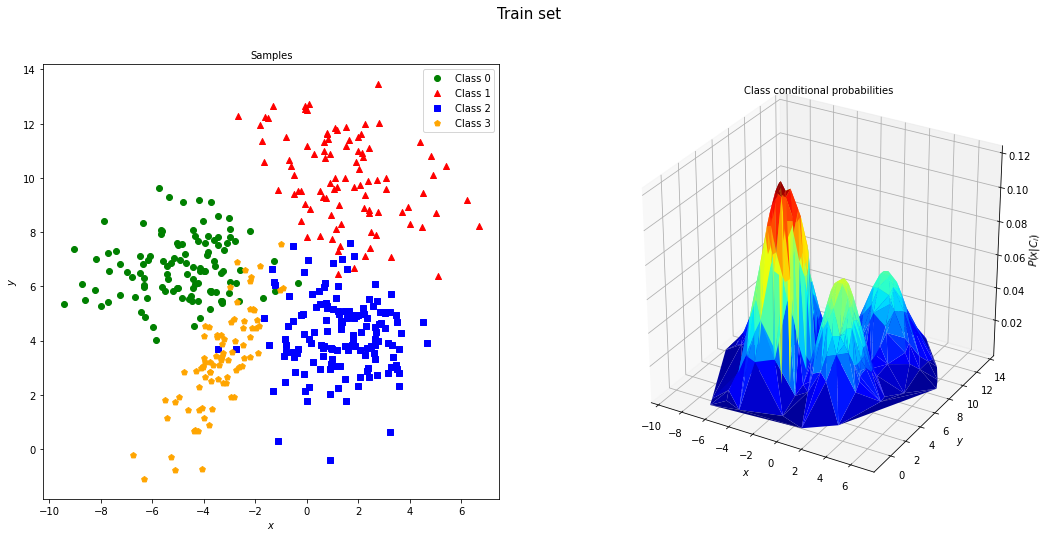

In [9]:
likelihood = calculate_likelihood(train_data, train_labels, mean, covariance)
plot_paras = ["Train set", ["o", "^", "s", "p"], ["green", "red", "blue", "orange"]]

data_2d_visualize(train_data, train_labels, likelihood, num_classes, plot_paras)

A classifier based on Bayes decision theory.

In [10]:
def naive_bayes_classifier(
    x, h, dim, covariance_kernel, num_classes, num_samples, data
):
    prior_probs = calculate_prior_probs(num_samples)
    likelihood = [
        calculate_PR_estimate(x, h, dim, covariance_kernel, data[i])
        for i in range(num_classes)
    ]
    posterior_probs = [likelihood[i] * prior_probs[i] for i in range(num_classes)]

    return posterior_probs.index(max(posterior_probs))

Group shuffled data into separate parts.

In [11]:
grouped_train_data = [[] for i in range(num_classes)]

for i in range(len(train_labels)):
    j = int(train_labels[i])
    grouped_train_data[j].append(train_data[i])

Set bandwidth to 0.5 and choose a standard Gaussian kernel.

In [12]:
h = 0.5
covariance_kernel = np.array([[1, 0], [0, 1]])

predicted_labels = [
    naive_bayes_classifier(
        x, h, dim, covariance_kernel, num_classes, num_samples, grouped_train_data
    )
    for x in test_data
]

Visualize test set.

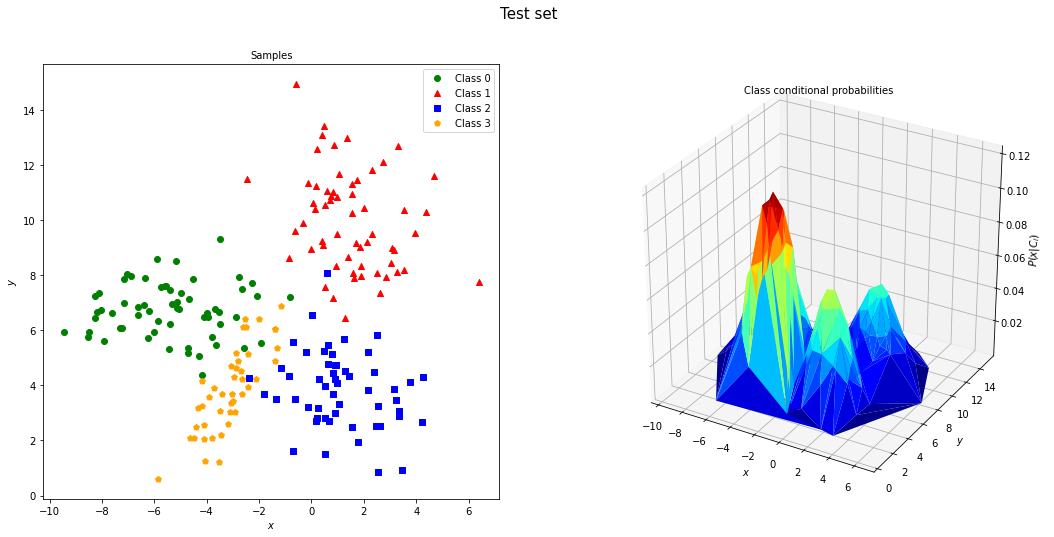

In [13]:
likelihood = calculate_likelihood(test_data, test_labels, mean, covariance)
plot_paras = ["Test set", ["o", "^", "s", "p"], ["green", "red", "blue", "orange"]]

data_2d_visualize(test_data, test_labels, likelihood, num_classes, plot_paras)

Visualize predicted set.

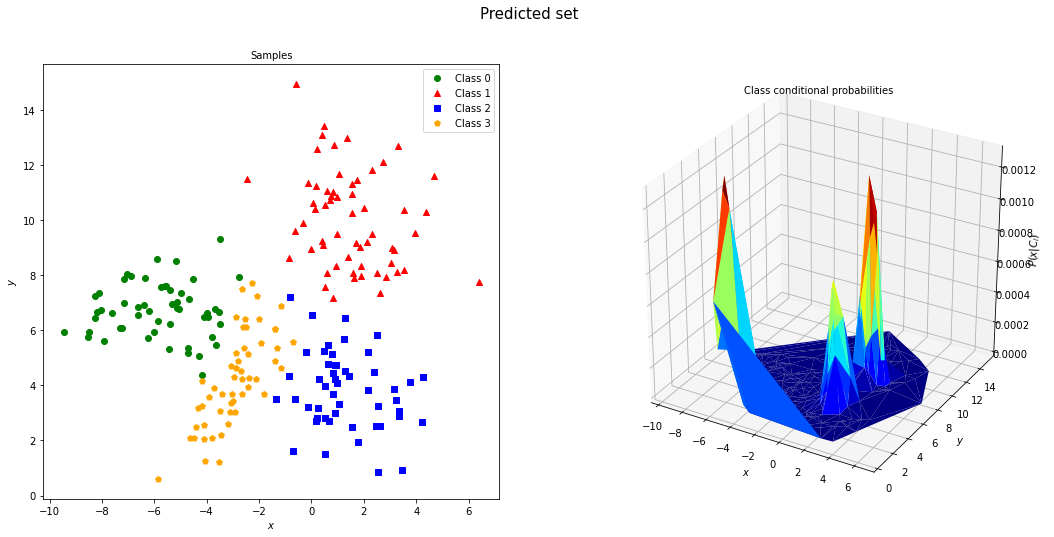

In [14]:
likelihood = [
    calculate_PR_estimate(
        test_data[i],
        h,
        dim,
        covariance_kernel,
        grouped_train_data[int(predicted_labels[i])],
    )
    for i in range(len(predicted_labels))
]
plot_paras = ["Predicted set", ["o", "^", "s", "p"], ["green", "red", "blue", "orange"]]

data_2d_visualize(test_data, predicted_labels, likelihood, num_classes, plot_paras)

Evaluation.

In [15]:
conf_mat = metrics.confusion_matrix(test_labels, predicted_labels)

conf_table = PrettyTable()

temp = ["C_{} (actual)".format(i) for i in range(num_classes)]
temp.insert(0, "Test set")
conf_table.field_names = temp

for i in range(num_classes):
    temp = [int(j) for j in conf_mat[i, :]]
    temp.insert(0, "C_{} (predicted)".format(i))
    conf_table.add_row(temp)

print(conf_table)

print("\n")

print(
    metrics.classification_report(
        test_labels,
        predicted_labels,
        target_names=["C_{}".format(i) for i in range(num_classes)],
        digits=2,
    )
)

+-----------------+--------------+--------------+--------------+--------------+
|     Test set    | C_0 (actual) | C_1 (actual) | C_2 (actual) | C_3 (actual) |
+-----------------+--------------+--------------+--------------+--------------+
| C_0 (predicted) |      53      |      0       |      1       |      6       |
| C_1 (predicted) |      0       |      58      |      1       |      0       |
| C_2 (predicted) |      0       |      1       |      48      |      4       |
| C_3 (predicted) |      0       |      0       |      0       |      43      |
+-----------------+--------------+--------------+--------------+--------------+


              precision    recall  f1-score   support

         C_0       1.00      0.88      0.94        60
         C_1       0.98      0.98      0.98        59
         C_2       0.96      0.91      0.93        53
         C_3       0.81      1.00      0.90        43

    accuracy                           0.94       215
   macro avg       0.94      0.9

# Reference

[1] M. Rosenblatt, “Remarks on Some Nonparametric Estimates of a Density Function,” *Ann. Math. Statist.*, vol. 27, no. 3, pp. 832–837, Sep. 1956, doi: 10.1214/aoms/1177728190.

[2] E. Parzen, “On Estimation of a Probability Density Function and Mode,” *Ann. Math. Statist.*, vol. 33, no. 3, pp. 1065–1076, Sep. 1962, doi: 10.1214/aoms/1177704472.    